# ML Pipeline de Operaciones en Flood para Predecir Destruction Level con RandomForestClassifier

## Objetivos

### Predecir Destruction Level (y numérica) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales a partir de percentiles y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Flood Type.
* OneHotEncoder para pasar de columna categórica Flood Type a numérica Destruction Level.
* Pipeline:
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas
    + RandomForestClassifier
* Modelado para predecir Destruction Level

## Importar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Imputador para columnas de Totales de Impacto


# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Destruction Level Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

In [2]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Cargar datos

In [3]:
df = pd.read_csv('../../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,Countrywide,NaN,Famine,0,Km2,NaN,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,NaN,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,14,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Frank, Alberta",NaN,NaN,0,NaN,NaN,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,NaN,NaN,NaN,0,NaN,NaN,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,Chittagong,NaN,NaN,0,Kph,NaN,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Spence's Bridge, British Columbia",NaN,NaN,0,NaN,NaN,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,32.04,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [4]:
df.shape

(16636, 26)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [6]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [7]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Flood

In [8]:
# Filtro principal para Flood
df_flood = df[df['Disaster Type'] == 'Flood']

### Limpieza

In [9]:
df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])
df_flood['Dis Mag Scale'].isnull().sum()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\2513547182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])


0

In [10]:
df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])
df_flood['Disaster Subtype'].isnull().sum()
df_flood['Disaster Subtype'].unique()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\2586547590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])


array(['Unknown', 'Riverine flood', 'Coastal flood', 'Flash flood'],
      dtype=object)

### Valores faltantes

#### Borrar columnas

In [11]:
df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\2601801454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)


In [12]:
df_flood.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0


In [13]:
print(df.isnull().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64


In [14]:
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64


In [15]:
# df_flood['Total Deaths'] = SimpleImputer(missing_values=0, strategy='mean').fit_transform(df_flood[['Total Deaths']])
# df_flood['Total Deaths'].describe()
# df_flood['Total Deaths'].isnull().sum()

In [16]:
# df_flood['Total Deaths'].value_counts()

In [17]:
df_flood.head(20)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0
34,Flood,Riverine flood,China,Eastern Asia,Asia,NaN,NaN,NaN,0,Km2,1911,0,0,1911,0,0,100000,0,0
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0
43,Flood,Riverine flood,China,Eastern Asia,Asia,Tianjin,NaN,NaN,0,Km2,1917,0,0,1917,0,0,0,635000,0
57,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Danube area,NaN,NaN,0,Km2,1920,8,0,1920,8,0,0,0,291520
75,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1925,12,0,1925,12,0,0,0,316357
81,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1926,6,0,1926,6,0,0,0,511311
84,Flood,Riverine flood,India,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,1926,7,19,1926,7,19,0,0,0
89,Flood,Unknown,Algeria,Northern Africa,Africa,Mostaganem,NaN,NaN,0,Km2,1927,11,1,1927,11,1,3000,0,0


## Preprocessing

## Preprocessing 1: crear columna categórica Flood Type y codificar columna numérica Destruction Level con OneHotEncoder para predecir y

### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [18]:
# df_flood = df[(df['Dis Mag Value'] > 0) & 
#                  (df['Total Deaths'] > 0) & 
#                  (df['Total Affected'] > 0) & 
#                  (df['Total Damages Adj'] > 0)]

In [19]:
df_flood['Dis Mag Value'].min()

0

In [20]:
df_flood.shape

(5808, 19)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [21]:
min_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min()
max_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max()
std_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median()

min_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min()
max_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max()
std_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std()
mean_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean()
median_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median()

min_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median()

.loc[df_flood['Dis Mag Value'].gt(0)]: El método .loc se usa para acceder a filas específicas del DataFrame según una condición. En este caso, la condición es df_flood['Dis Mag Value'].gt(0), que verifica si los valores en la columna 'Dis Mag Value' son mayores que 0. Esta condición crea una máscara booleana, donde cada elemento en el DataFrame se reemplaza con True si es mayor que 0 y False en caso contrario.

In [22]:
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median())

print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median())

print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median())

print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median())

2
2857000
206861.50686270732
92063.0765334834
24681.0
1
3700000
65196.51587469585
1656.5946073793757
16.0
2
238973000
7561334.5755781615
811324.9760785116
11000.0
5
53860097
3156399.414884343
861012.3965244866
87845.0


### Umbrales con percentiles

#### Value counts de 'Dis Mag Value'

In [23]:
df_flood['Dis Mag Value'].value_counts()

0          4031
100           8
200           7
3000          7
550           6
10            6
1000          6
60            6
300           5
150           5
1200          5
400           5
8000          4
70            4
4900          4
500           4
600           4
35            3
17000         3
9             3
108           3
5300          3
1100          3
850           3
4600          3
1400          3
20            3
630           3
560           3
290           3
18            3
22760         3
4             3
2500          3
55860         3
10000         3
110           3
700           3
80            3
2000          3
11140         2
4050          2
4630          2
730           2
190           2
390           2
1980          2
19200         2
7700          2
250           2
18940         2
37320         2
5180          2
1170          2
180760        2
960           2
20490         2
14990         2
4200          2
12680         2
44620         2
32700         2
350     

In [24]:
print(df_flood['Dis Mag Value'].unique())

# value counts de cada valor único en orden descendiente
print(df_flood['Dis Mag Value'].value_counts().sort_index(ascending=False))


[     0   3000 150000 ...  33791  18949   4232]
2857000       1
2643786       1
2440002       1
1834048       1
1829701       1
1668000       1
1591000       1
1341347       1
1330000       1
1287000       1
1232000       1
1217000       1
1215862       1
1186000       1
1164000       1
1140146       1
1120000       1
1037639       1
1015000       1
955800        1
911256        1
849465        1
840000        1
832001        1
812700        1
810942        1
801000        1
776608        1
762900        1
761154        1
720844        1
689100        1
678500        1
649500        1
645400        1
634200        1
632316        1
630100        1
629962        1
629242        1
625200        1
624200        1
619200        1
619100        1
614000        1
587384        1
585146        1
582300        1
578300        1
577783        1
574057        1
571700        1
565200        1
554200        1
545400        1
544053        1
542100        1
538000        1
524900        1
524400  

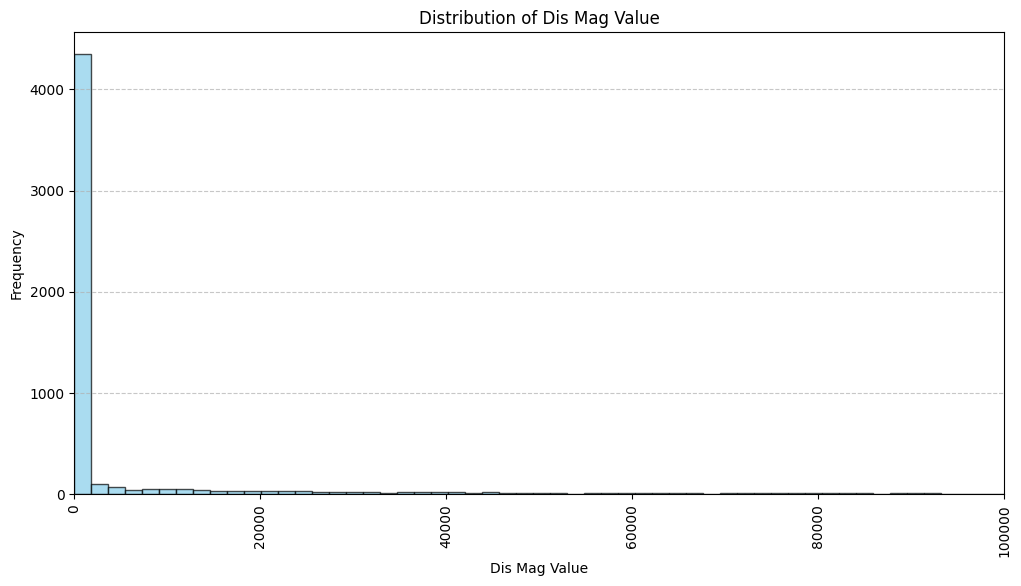

In [25]:
# value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Dis Mag Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dis Mag Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-axis limits para zoom
plt.xlim(0, 100000)

plt.show()

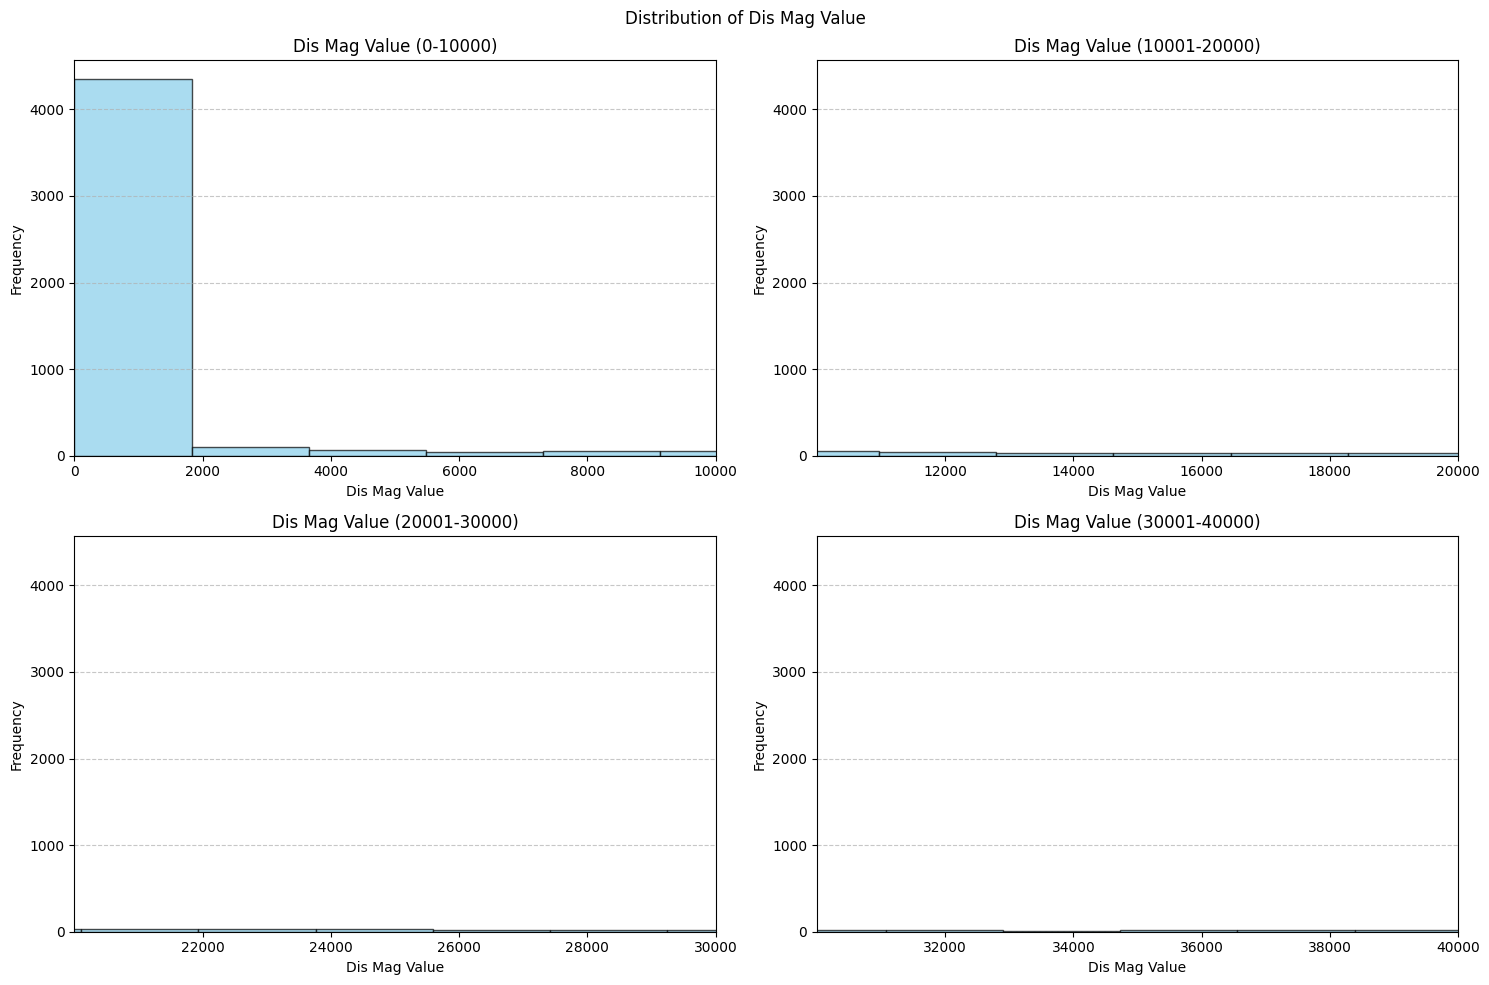

In [26]:
# Value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribución de Dis Mag Value')

# Rangos de zoom para cada subplot
zoom_ranges = [(0, 10000), (10001, 20000), (20001, 30000), (30001, 40000), (40001, 50000)]

# Sector segmentado por zoom
for i, ax in enumerate(axes.flat):
    lower_limit, upper_limit = zoom_ranges[i]
    ax.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
    ax.set_xlabel('Dis Mag Value')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Dis Mag Value ({lower_limit}-{upper_limit})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [27]:
mask = df['Dis Mag Value'] != 0

# Calcular percentiles 25, 50 y 75 para Dis Mag Value, excluyendo 0

type1_threshold = np.percentile(df_flood.loc[mask, 'Dis Mag Value'], 25)
type2_threshold = np.percentile(df_flood.loc[mask, 'Dis Mag Value'], 50)
type3_threshold = np.percentile(df_flood.loc[mask, 'Dis Mag Value'], 75)

print(f'Umbral 1: {type1_threshold}')
print(f'Umbral 2: {type2_threshold}')
print(f'Umbral 3: {type3_threshold}')

Umbral 1: 4210.0
Umbral 2: 24681.0
Umbral 3: 84762.0


### Función para crear columna categórica de nivel de impacto: Flood Type

In [28]:
# Función previa que no considera valores nulos
def assign_flood_type(row):
    if row['Dis Mag Value'] < type1_threshold and row['Total Deaths'] < 100 and row['Total Affected'] < 10000 and row['Total Damages Adj'] < 1000000:
        return 'Low' # 1
    elif row['Dis Mag Value'] < type2_threshold and row['Total Deaths'] < 500 and row['Total Affected'] < 100000 and row['Total Damages Adj'] < 10000000:
        return 'Moderate' # 2
    elif row['Dis Mag Value'] < type3_threshold and row['Total Deaths'] < 1000 and row['Total Affected'] < 500000 and row['Total Damages Adj'] < 100000000:
        return 'High' # 3
    else:
        return 'Very High' # 4

In [29]:
df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)
df_flood.head(20)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\3488395721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0,Low
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0,Low
34,Flood,Riverine flood,China,Eastern Asia,Asia,NaN,NaN,NaN,0,Km2,1911,0,0,1911,0,0,100000,0,0,Very High
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High
43,Flood,Riverine flood,China,Eastern Asia,Asia,Tianjin,NaN,NaN,0,Km2,1917,0,0,1917,0,0,0,635000,0,Very High
57,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Danube area,NaN,NaN,0,Km2,1920,8,0,1920,8,0,0,0,291520,Low
75,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1925,12,0,1925,12,0,0,0,316357,Low
81,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1926,6,0,1926,6,0,0,0,511311,Low
84,Flood,Riverine flood,India,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,1926,7,19,1926,7,19,0,0,0,Low
89,Flood,Unknown,Algeria,Northern Africa,Africa,Mostaganem,NaN,NaN,0,Km2,1927,11,1,1927,11,1,3000,0,0,Very High


### Codificación categórica a numérica

#### Convertir Flood Type a Destruction Level numérica con OneHotEncoder

In [30]:
# Crear instancia de OneHotEncoder
encoder = OneHotEncoder()

# Ajustar y transformar la columna 'Flood Type' con el encoder OneHotEncoder()
flood_type_encoded = encoder.fit_transform(df_flood[['Flood Type']]).toarray()

# Obtener valores únicos en columna 'Flood Type'
unique_flood_types = df_flood['Flood Type'].unique()

# Definir un diccionario de mapeo para las categorías en 'Flood Type' a valores numéricos
destruction_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

# Crear una nueva columna 'Destruction Level' mapeando las categorías 'Flood Type' a valores numéricos
df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)

# Aplicar get_dummies a columna 'Flood Type'
destruction_encoded = pd.get_dummies(df_flood['Destruction Level'], prefix='Destruction')

# Concatenar el DataFrame codificado con el original
df_flood_encoded = pd.concat([df_flood, destruction_encoded], axis=1)

# DataFrame actualizado
print(df_flood_encoded.head())


   Disaster Type Disaster Subtype  Country          Region Continent  \
12         Flood          Unknown  Belgium  Western Europe    Europe   
13         Flood          Unknown  Belgium  Western Europe    Europe   
34         Flood   Riverine flood    China    Eastern Asia      Asia   
39         Flood   Riverine flood    China    Eastern Asia      Asia   
43         Flood   Riverine flood    China    Eastern Asia      Asia   

          Location Origin Associated Dis  Dis Mag Value Dis Mag Scale  \
12  Louvain region    NaN            NaN              0           Km2   
13             NaN    NaN            NaN              0           Km2   
34             NaN    NaN            NaN              0           Km2   
39       Guangzhou    NaN            NaN           3000           Km2   
43         Tianjin    NaN            NaN              0           Km2   

    Start Year  Start Month  Start Day  End Year  End Month  End Day  \
12        1906            5         14      1906        

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\220147197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)


#### Revisión df_flood_encoded

In [31]:
df_flood_encoded.shape

(5808, 25)

In [32]:
len(df_flood_encoded)

5808

In [33]:
df_flood_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5808 entries, 12 to 16634
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Disaster Type      5808 non-null   object
 1   Disaster Subtype   5808 non-null   object
 2   Country            5808 non-null   object
 3   Region             5808 non-null   object
 4   Continent          5808 non-null   object
 5   Location           5512 non-null   object
 6   Origin             3446 non-null   object
 7   Associated Dis     1383 non-null   object
 8   Dis Mag Value      5808 non-null   int64 
 9   Dis Mag Scale      5808 non-null   object
 10  Start Year         5808 non-null   int64 
 11  Start Month        5808 non-null   int64 
 12  Start Day          5808 non-null   int64 
 13  End Year           5808 non-null   int64 
 14  End Month          5808 non-null   int64 
 15  End Day            5808 non-null   int64 
 16  Total Deaths       5808 non-null   int64

In [34]:
df_flood.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [35]:
df_flood['Destruction Level']

12       1
13       1
34       4
39       4
43       4
57       1
75       1
81       1
84       1
89       4
92       1
100      1
110      4
120      4
123      4
138      4
176      2
180      2
188      4
191      4
196      3
197      4
199      1
200      2
202      2
205      4
209      1
211      1
219      1
223      1
224      1
225      2
227      1
234      4
235      4
238      1
246      1
257      1
258      1
262      4
269      1
270      2
271      1
272      2
273      3
274      1
276      2
277      1
278      1
279      2
284      1
289      1
290      4
292      2
296      2
297      2
299      1
300      2
301      2
302      3
309      4
313      1
323      1
329      2
331      2
334      1
335      2
339      1
345      2
349      3
356      4
357      3
358      2
359      1
365      2
380      1
381      2
382      3
388      3
394      2
401      1
404      3
409      4
412      1
413      1
415      2
416      3
418      1
423      2
432      2
436      4

In [36]:
df_flood['Destruction Level'].isnull().sum()

0

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [37]:
# Imputar nulos en la columna de salida (y) que es Destruction Level
df_flood['Destruction Level'] = SimpleImputer(missing_values=0, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])
df_flood['Destruction Level']
# Se prueba a cambiar np_nan por 0 
# borrar en lugar de imputar
# df = df.dropna('Flood Type')

C:\Users\AleEng\AppData\Local\Temp\ipykernel_8664\3417749100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = SimpleImputer(missing_values=0, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])


12       1
13       1
34       4
39       4
43       4
57       1
75       1
81       1
84       1
89       4
92       1
100      1
110      4
120      4
123      4
138      4
176      2
180      2
188      4
191      4
196      3
197      4
199      1
200      2
202      2
205      4
209      1
211      1
219      1
223      1
224      1
225      2
227      1
234      4
235      4
238      1
246      1
257      1
258      1
262      4
269      1
270      2
271      1
272      2
273      3
274      1
276      2
277      1
278      1
279      2
284      1
289      1
290      4
292      2
296      2
297      2
299      1
300      2
301      2
302      3
309      4
313      1
323      1
329      2
331      2
334      1
335      2
339      1
345      2
349      3
356      4
357      3
358      2
359      1
365      2
380      1
381      2
382      3
388      3
394      2
401      1
404      3
409      4
412      1
413      1
415      2
416      3
418      1
423      2
432      2
436      4

In [38]:
df_flood['Flood Type'].isna().sum()
df_flood['Flood Type'].unique()
len(df_flood['Flood Type'])

5808

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

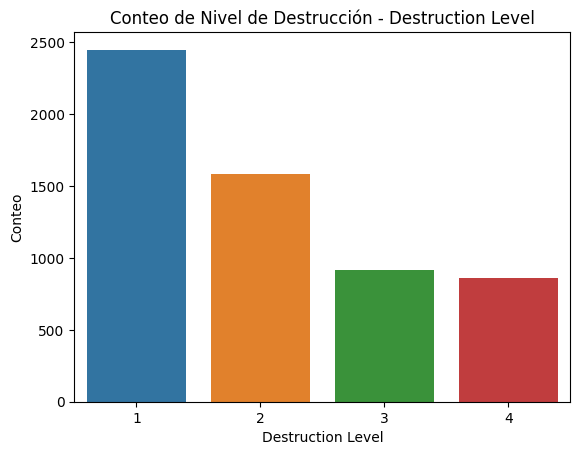

In [39]:
sns.countplot(data=df_flood, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

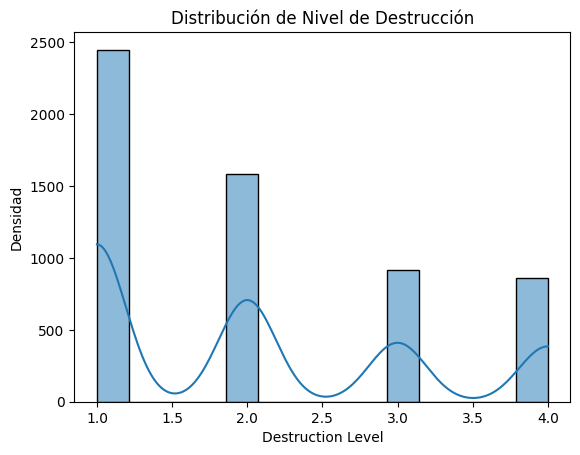

In [40]:
sns.histplot(data=df_flood, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

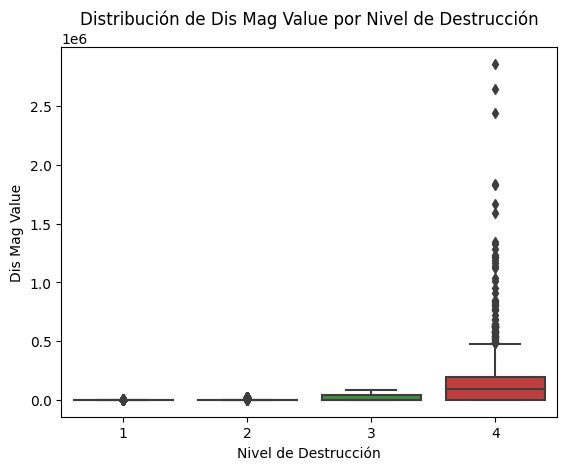

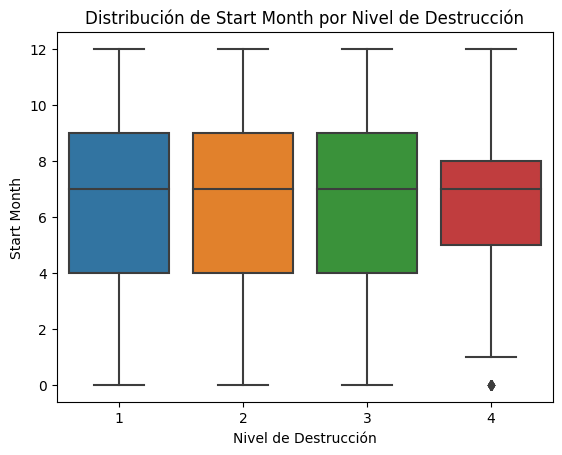

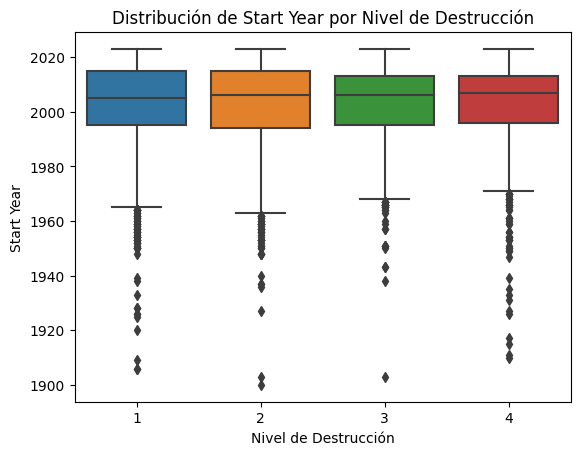

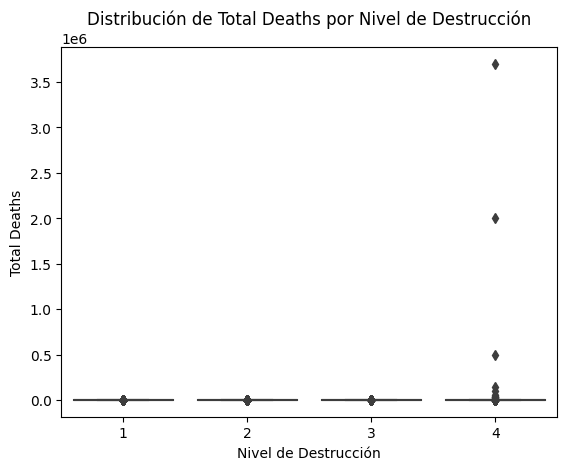

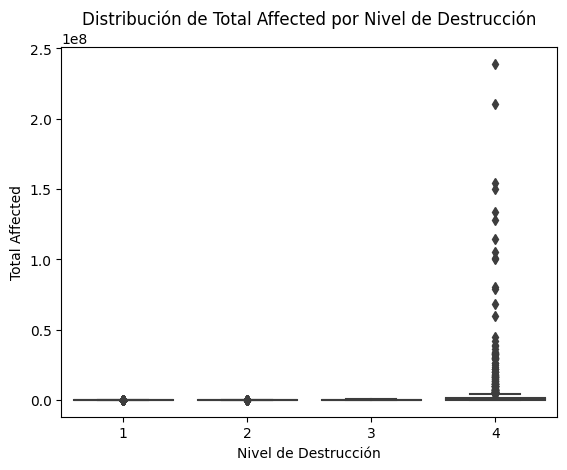

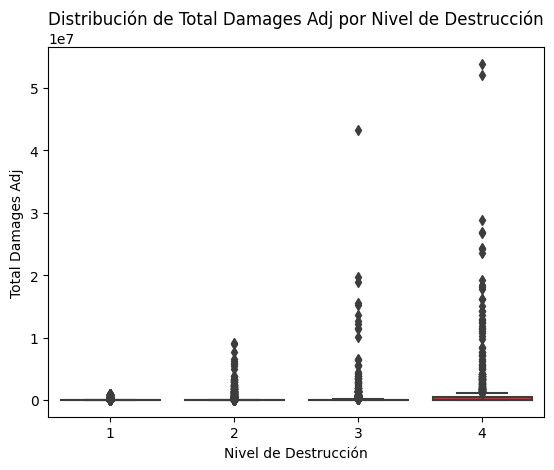

In [41]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_flood, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

In [42]:
# sns.pairplot(df_flood)
# Demasiado tiempo para procesar

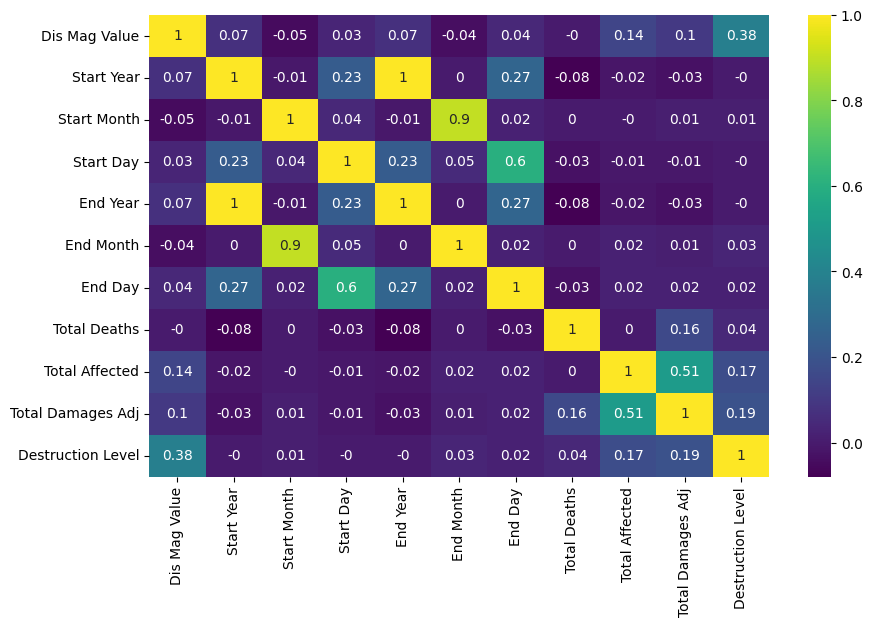

In [43]:
plt.figure(figsize=(10, 6))
df_corr = df_flood.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

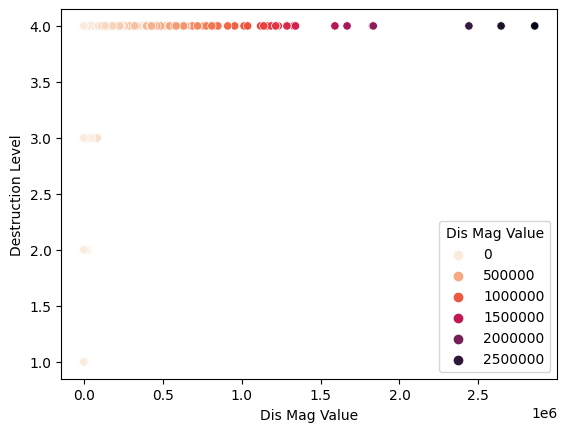

In [44]:
sns.scatterplot(data=df_flood, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

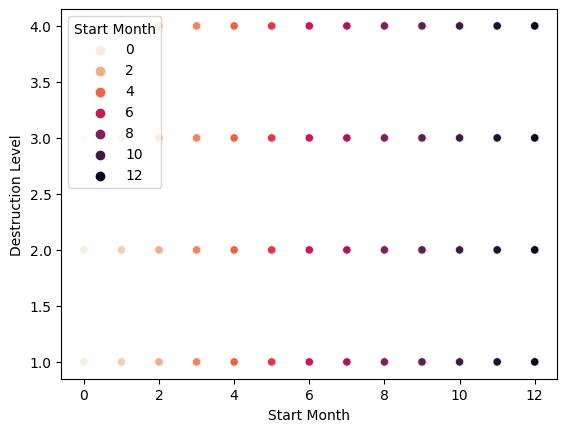

In [45]:
sns.scatterplot(data=df_flood, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

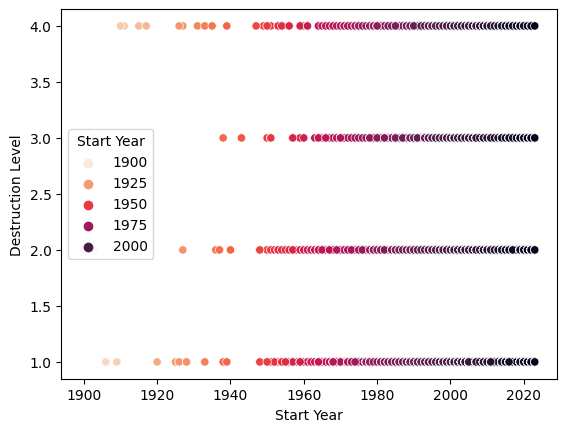

In [46]:
sns.scatterplot(data=df_flood, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

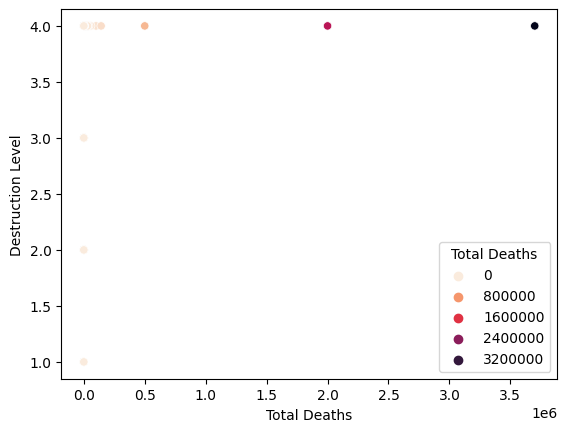

In [47]:
sns.scatterplot(data=df_flood, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

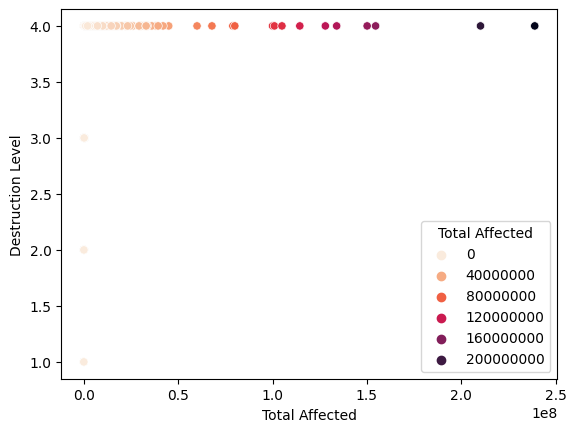

In [48]:
sns.scatterplot(data=df_flood, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

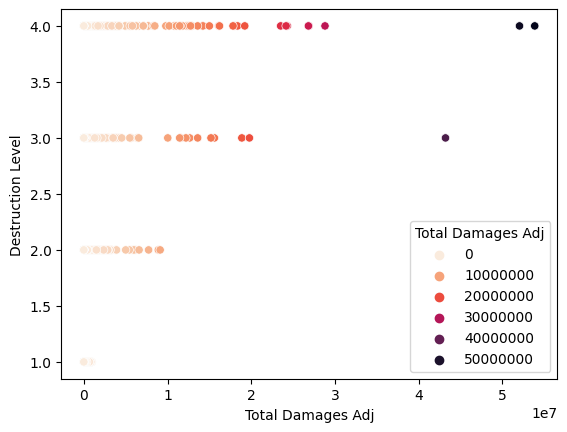

In [49]:
sns.scatterplot(data=df_flood, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

## Preparar X y

In [50]:
# X = df_flood.drop(['Destruction Level', 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4'], axis=1)
# Dio problemas porque 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4' no existen en df_flood

X = df_flood.select_dtypes(exclude=['object'])  # Excluir columnas categóricas
X = X.drop('Destruction Level', axis=1)  # Quitar 'Destruction Level' de X
y = df_flood['Destruction Level']

## train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (4646, 10), (4646,)
test: (1162, 10), (1162,)


### SMOTE Balanceo de clases

In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"original: {X_train.shape} {y_train.shape}")
print(f"resampled: {X_train_res.shape} {y_train_res.shape}")

# comprobar que se han balanceado las clases
y_train_res.value_counts()

original: (4646, 10) (4646,)
resampled: (7872, 10) (7872,)


3    1968
1    1968
4    1968
2    1968
Name: Destruction Level, dtype: int64

# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [53]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
    ('scaler', StandardScaler()),  # Escalar características numéricas
    ('classifier', RandomForestClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
])

## Ejecución de pipeline

### Entrenar el modelo

In [54]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

#### Explicación de pipeline:
Incluye los siguientes pasos: SimpleImputer, StandardScaler y RandomForestClassifier.
* SimpleImputer para manejar los valores faltantes en los datos.
* StandardScaler para estandarizar las características numéricas, asegurando que tengan una media cero y una varianza unitaria.
* RandomForestClassifier es el modelo de clasificación elegido.

## Ejecución de pipeline

In [55]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [56]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.pkl') # más genérico
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.joblib') # más eficiente con muchos datos

['pipelineRFC_Flood_DestructionLvl.joblib']

## Cargar pipeline

In [57]:
pipeline = joblib.load('pipelineRFC_Flood_DestructionLvl.joblib')
pipeline.predict(X_test)[:10]

array([2, 4, 2, 1, 2, 1, 1, 1, 1, 1], dtype=int64)

# Evaluar Modelo

### Predicción y_pred

In [58]:
y_pred = pipeline.predict(X_test)

In [59]:
y_pred.shape

(1162,)

# Últimas comprobaciones dataframe

In [60]:
df_flood.head(100)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type,Destruction Level
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0,Low,1
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0,Low,1
34,Flood,Riverine flood,China,Eastern Asia,Asia,NaN,NaN,NaN,0,Km2,1911,0,0,1911,0,0,100000,0,0,Very High,4
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High,4
43,Flood,Riverine flood,China,Eastern Asia,Asia,Tianjin,NaN,NaN,0,Km2,1917,0,0,1917,0,0,0,635000,0,Very High,4
57,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Danube area,NaN,NaN,0,Km2,1920,8,0,1920,8,0,0,0,291520,Low,1
75,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1925,12,0,1925,12,0,0,0,316357,Low,1
81,Flood,Unknown,Germany Fed Rep,Western Europe,Europe,Rhine area,NaN,NaN,0,Km2,1926,6,0,1926,6,0,0,0,511311,Low,1
84,Flood,Riverine flood,India,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,1926,7,19,1926,7,19,0,0,0,Low,1
89,Flood,Unknown,Algeria,Northern Africa,Africa,Mostaganem,NaN,NaN,0,Km2,1927,11,1,1927,11,1,3000,0,0,Very High,4


In [61]:
df_flood.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [62]:
df_flood.isnull().sum()

Disaster Type           0
Disaster Subtype        0
Country                 0
Region                  0
Continent               0
Location              296
Origin               2362
Associated Dis       4425
Dis Mag Value           0
Dis Mag Scale           0
Start Year              0
Start Month             0
Start Day               0
End Year                0
End Month               0
End Day                 0
Total Deaths            0
Total Affected          0
Total Damages Adj       0
Flood Type              0
Destruction Level       0
dtype: int64

In [63]:
df_flood['Destruction Level'].min()

1

### Pivot Tables

In [64]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [65]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,4170,9993,965725,99
2,24415,99185,9116027,498
3,84662,498924,43201120,992
4,2857000,238973000,53860097,3700000


In [66]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,278205,4118321,67485083,25814
2,4659410,40911068,234857439,55997
3,19725722,128371993,374476983,50181
4,138932750,3794789076,958243036,6872090


In [67]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,113.645833,1.682321e+03,2.756744e+04,10.544935
2,2945.265487,2.586035e+04,1.484560e+05,35.396334
3,21511.147219,1.399913e+05,4.083718e+05,54.723010
4,161362.078978,4.407421e+06,1.112942e+06,7981.521487


In [68]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,0,589.5,0,3
2,0,18311.5,0,7
3,1746,120000.0,0,14
4,88871,506000.0,12623,41


# Reporte de Clasificación

La precisión, la recuperación y la puntuación F1 son métricas de evaluación de uso común en modelos de aprendizaje automático, particularmente en tareas de clasificación. Estas métricas brindan información sobre el rendimiento del modelo y su capacidad para clasificar correctamente las instancias.

* Precision: la precisión mide la proporción de instancias positivas pronosticadas correctamente (positivos verdaderos) de todas las instancias pronosticadas como positivas (positivos verdaderos + positivos falsos). En otras palabras, la precisión indica qué tan preciso o exacto es el modelo cuando predice una clase positiva. Una puntuación de alta precisión sugiere que el modelo tiene una baja tasa de falsos positivos.

* Recall: la recuperación, también conocida como sensibilidad o tasa de verdaderos positivos, mide la proporción de instancias positivas pronosticadas correctamente (verdaderos positivos) de todas las instancias positivas reales (verdaderos positivos + falsos negativos). Representa la capacidad del modelo para identificar o capturar instancias positivas. Una puntuación de recuerdo alta sugiere que el modelo tiene una tasa baja de falsos negativos.

* f1-score: La puntuación F1 es la media armónica de precisión y recuperación. Proporciona una medida equilibrada que considera simultáneamente la precisión y la recuperación. La puntuación F1 combina precisión y recuperación en una sola métrica y proporciona una evaluación más completa del rendimiento del modelo. Es especialmente útil cuando se trata de conjuntos de datos desequilibrados, donde la distribución de clases es desigual.

Al interpretar estas métricas, es fundamental tener en cuenta los objetivos y requisitos específicos de la tarea de clasificación. Es deseable una puntuación de alta precisión cuando es crucial minimizar los falsos positivos. Por otro lado, una puntuación alta de recuerdo es deseable cuando la captura de tantos positivos verdaderos como sea posible es una prioridad. La puntuación F1 proporciona una vista equilibrada, teniendo en cuenta tanto la precisión como la recuperación.

En resumen, la precisión, la recuperación y la puntuación F1 son métricas valiosas para evaluar el rendimiento de un modelo de clasificación, que brindan información sobre su precisión, capacidad para capturar instancias positivas y rendimiento general equilibrado.

In [69]:
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       480
           2       0.99      1.00      0.99       315
           3       0.99      0.99      0.99       184
           4       1.00      0.99      1.00       183

    accuracy                           1.00      1162
   macro avg       1.00      0.99      1.00      1162
weighted avg       1.00      1.00      1.00      1162



Resultados de 1er reporte de clasificación

Reporte de Clasificación 1:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       584
           2       0.98      1.00      0.99       312
           3       0.99      0.99      0.99       155
           4       1.00      0.99      1.00       111

    accuracy                           0.99      1162
   macro avg       0.99      0.99      0.99      1162
weighted avg       0.99      0.99      0.99      1162

Según el informe de clasificación, el modelo parece funcionar bien, logrando una alta precisión, recuperación y puntuación F1 para cada clase. La alta precisión sugiere que el modelo es capaz de predecir el 'Nivel de destrucción' con un alto grado de corrección. Sin embargo, es importante tener en cuenta que sería necesario un mayor análisis y consideración de otras métricas de evaluación, como la validación cruzada o la validación de datos no vistos, para obtener una evaluación integral del rendimiento del modelo.

#### Interpretación de primer Reporte de Clasificación con RandomForestClassifier:

### Evaluación con mae, rmse y r2

In [70]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 0.004302925989672977
Root Mean Squared Error (RMSE): 0.06559669191104821
Coefficient of Determination (R^2): 0.9964074862791946


#### Resultados de mae, rmse y r2
* Los valores varían cada vez que se vuelve a cargar el notebook

Mean Absolute Error (MAE): 0.006024096385542169
+ El MAE representa la diferencia absoluta promedio entre los valores pronosticados y los valores reales. En este caso, la diferencia absoluta promedio es muy pequeña, lo que indica que las predicciones del modelo son, en promedio, muy cercanas a los valores reales.


Error cuadrático medio (RMSE): 0.08800719732732863
* El RMSE mide la desviación estándar de los residuos, que representa la distancia promedio entre los valores predichos y los valores reales. El valor RMSE de 0,0718 indica que, en promedio, los valores pronosticados están muy cerca de los valores reales.


Coeficiente de Determinación (R^2): 0.9921474519014535

* La puntuación R^2, también conocida como coeficiente de determinación, mide la proporción de varianza en la variable dependiente que puede ser explicada por las variables independientes. Un valor de 0,9947 indica que el modelo explica aproximadamente el 99,47% de la varianza de la variable objetivo. Esto sugiere que el modelo funciona muy bien al capturar los patrones y tendencias subyacentes en los datos.

El informe de clasificación proporciona métricas de evaluación para el modelo RandomForestClassifier.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

# Conclusiones de la versión 4 o Test D

## Sobre resultados del modelo y comparación con versión 4

De acuerdo al reporte de clasificación, los resultados de la evaluación indican que el modelo RandomForestClassifier v1 tiene una alta precisión y funciona bien en la predicción del Nivel de Destrucción ('Destruction Level') en función de la mezcla de características dadas por Total Deaths, Total Affected, Total Damages Adj. Los valores pequeños de MAE y RMSE, así como la puntuación alta de R^2, demuestran la eficacia del modelo para capturar las relaciones entre las variables independientes y dependientes.

Sin embargo, cabe recordar que en el test B o versión 2 se realizó un filtro previo para excluir los valores de 0 en columnas de Dis Mag Value, Total Deaths, Total Affected y Total Damages Adj, provocando que los resultados de densidad de los Niveles de Destrucción varíen mucho respecto a los del test A donde se conservaron valores íntegros, es decir, también se consideraron las filas con 0 que mostraban alguna relación o valor perteneciente a Filtro Flood.

El test A o versión 1 se desempeña mejor que test B o versión 2 en los resultados, aunque la duda de si deben conservarse los valores totales persiste.

# Recomendaciones

Para mejorar el modelo, hay que buscar una solución o fórmula más fiable para definir los umbrales de Tipo de Inundación o Nivel de Destrucción, previos a implementar cualquier modelo, ya que, de momento, los rangos son un tanto indiscriminados, aunque se apoyan en la distribución entre todas las columnas de impacto.

Puede ser que este modelo esté siendo sesgado en cuanto al reparto de Tipos de Inundación, ya que está considerando los 0 en nivel 1, produciendo un incremento en el Nivel de Destrucción para este tipo.

Aunque en el desempeño parezca que el Test A funciona mejor, es más confiable excluir los valores 0 previamente, aunque se reduzca la muestra considerablemente.

Si el 'Valor Dis Mag' de 0 indica datos faltantes o desconocidos, podría ser mejor excluir esas filas de la predicción del modelo. Al hacerlo, se asegura de que el modelo haga predicciones solo en función de datos significativos y confiables. Incluir filas con valores faltantes o desconocidos en la predicción puede generar ruido y afectar potencialmente la precisión de las predicciones del modelo.

Por otro lado, el modelo también podría estar aprendendiendo de datos disponibles de otras columnas donde sí hay valores relacionados al evento Flood (recordemos que se realizó un filtro previo específico) aunque en 'Dis Mag Value' aparezca 0, y hacer predicciones en consecuencia.

En resumen, la decisión de filtrar filas de manera segmentada con 'Dis Mag Value' u otras columnas pretende abordar el reto específico de nuestro dataset que es la inconsistencia de los mismos, debido a que no son fenómenos que ocurran de una forma constante ni ordenada, sino más bien aleatoria y dependiente de otros factores con los que no contamos, incluyendo muchos que no se recolectaron.